从零开始实现整个线性回归过程，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [4]:
%matplotlib inline
import random,torch
from d2l import torch as d2l

根据带有噪声的线性模型构建人造数据集，使用线性模型参数$w=[2,-3,4]^T$、b=4.2和噪声项$\epsilon$生辰数据集及其标签：$y=Xw+b+\epsilon$

In [5]:
def synthetic_data(w, b, num_examples):  #@save
    """生成 y = Xw + b + 噪声"""
    #噪声项为0.01
    X = torch.normal(0, 1, (num_examples, len(w))) 
    #torch.normal(means,std,out=None)返回一个张量，包含从给定参数means,std的离散正态分布中抽取随机数
    y = torch.matmul(X, w) + b
    # torch.matmul 是tensor的乘法，输入可以是高维的。
    #当输入的都二维是，该函数和tensor.mm函数用法相同
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
#features中每一行都包含一个二维数据样本，labels中每一行都包含一维标签值(一个标量)
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([-0.9482, -1.1506]) 
label: tensor([6.2088])


通过生成第二个特征features[:, 1]和labels的散点图，可以直观地观察到两者之间的线性关系

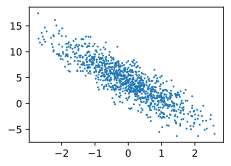

In [7]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)

定义`data_iter`函数，该函数接受批量大小、特征矩阵和标签向量作为输入，生成`batch_size`的小批量

In [9]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
batch_size = 10
for x,y in data_iter(batch_size, features, labels):
    print(x,'\n',y,'\n')
    break

tensor([[ 0.2157,  2.3387],
        [-0.0586, -1.6063],
        [-0.2338,  0.7100],
        [-0.2820,  0.9088],
        [ 0.1600,  0.3145],
        [-1.2201,  0.9125],
        [ 1.6859, -0.8325],
        [ 0.9436,  0.9624],
        [ 0.6287, -1.4940],
        [-0.9774, -1.1486]]) 
 tensor([[-3.3305],
        [ 9.5454],
        [ 1.3332],
        [ 0.5416],
        [ 3.4513],
        [-1.3441],
        [10.4109],
        [ 2.8150],
        [10.5466],
        [ 6.1502]]) 



In [32]:
# 定义初始化模型参数
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

In [33]:
# 定义模型
def linreg(x,w,b):
    '''线性回归模型'''
    return torch.matmul(x,w)+b

In [14]:
# 定义损失函数
def squared_loss(y_hat,y):
    '''均方损失'''
    return (y_hat - y.reshape(y_hat.shape))**2 /2

In [15]:
#定义优化算法
def sgd(params,lr,batch_size):
    '''小批量随机梯度下降'''
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [34]:
#训练过程
lr = 0.01
num_epochs = 10
net = linreg
loss = squared_loss
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # `X`和`y`的小批量损失
        # 因为`l`形状是(`batch_size`, 1)，而不是一个标量。`l`中的所有元素被加到一起，
        # 并以此计算关于[`w`, `b`]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 2.214744
epoch 2, loss 0.296603
epoch 3, loss 0.039851
epoch 4, loss 0.005420
epoch 5, loss 0.000776
epoch 6, loss 0.000148
epoch 7, loss 0.000062
epoch 8, loss 0.000050
epoch 9, loss 0.000049
epoch 10, loss 0.000049


In [22]:
#比较真是参数和训练习得的参数来评估训练的成功程度
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0002, -0.0005], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)


# 线性回归的简洁实现
通过使用深度学习框架来简洁地实现线性回归模型生成数据集

In [36]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b,1000)

读取数据集

In [37]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器。"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)


#使用next从迭代器种获取一项
next(iter(data_iter))

[tensor([[-0.1090,  1.6360],
         [-0.7554,  2.1785],
         [ 1.0552, -0.4924],
         [-1.0681, -0.8174],
         [-2.0667,  0.5291],
         [ 0.4244, -0.7032],
         [-0.8723,  0.4764],
         [ 0.6926,  1.6611],
         [ 0.3235,  0.1073],
         [-1.1752,  1.7852]]),
 tensor([[-1.5732],
         [-4.7307],
         [ 7.9548],
         [ 4.8477],
         [-1.7328],
         [ 7.4315],
         [ 0.8353],
         [-0.0555],
         [ 4.4852],
         [-4.2313]])]

定义模型

In [38]:
#nn是神经网络的缩写
from torch import nn
#nn.Linear的第一个参数指定输入特征形状，第二个参数指定输出特征形状
net = nn.Sequential(nn.Linear(2,1))

In [40]:
#初始化模型参数
net[0].weight.data.normal_(0,0.01) #用正态分布
net[0].bias.data.fill_(0)

tensor([0.])

In [41]:
#使用MSELoss类计算均方误差，也称L2范数
loss = nn.MSELoss()

In [42]:
#实例化SGD
trainer = torch.optim.SGD(net.parameters(),lr=0.03)

In [47]:
#训练过程代码
num_epochs = 10
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()#梯度清零
        l.backward()
        trainer.step() #梯度自动更新
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000095
epoch 2, loss 0.000095
epoch 3, loss 0.000095
epoch 4, loss 0.000095
epoch 5, loss 0.000095
epoch 6, loss 0.000095
epoch 7, loss 0.000095
epoch 8, loss 0.000094
epoch 9, loss 0.000095
epoch 10, loss 0.000096


In [44]:
#误差估计
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([ 0.0002, -0.0001])
b的估计误差： tensor([-0.0005])
